In [2]:
!pip install shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import shap
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
%matplotlib inline

     |████████████████████████████████| 358kB 6.2MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491623 sha256=0134134d0ce5403940c0f0c917dbfe3246240b47a15076a1f28e48361e0e01e1
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [3]:
df_train_path = os.path.join('/content/drive/MyDrive/data','df_train_scaled.csv')
df_test_path = os.path.join('/content/drive/MyDrive/data','df_test_scaled.csv')

#download in chunks
df_train = pd.read_csv(df_train_path, index_col=0, compression='zip')
df_test = pd.read_csv(df_test_path, index_col=0, compression='zip')

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [4]:
df_train.shape,df_test.shape

((1073090, 21), (194208, 21))

In [5]:
target_col = 'loan_status'

#feature space
X_train = df_train.drop(columns=[target_col])
X_test = df_test.drop(columns=[target_col])

#target variable
y_train = df_train[target_col]
y_test = df_test[target_col]



In [6]:
bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X_train,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfpvalue= pd.DataFrame(fit.pvalues_)
dfcolumns = pd.DataFrame(X_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfpvalue,dfscores],axis=1)
featureScores.columns = ['Specs','pvalue','Score']  #naming the dataframe columns
print(featureScores.nlargest(21,'Score'))  #print 10 best features

                   Specs         pvalue         Score
3              sub_grade   0.000000e+00  85040.105921
2                  grade   0.000000e+00  81124.312578
1               int_rate   0.000000e+00  79815.493509
0                   term   0.000000e+00  43421.239487
17    balance_annual_inc   0.000000e+00  20533.768543
18        fico_avg_score   0.000000e+00  18917.563100
9                    dti   0.000000e+00  13431.938020
19       inst_amnt_ratio   0.000000e+00   6027.993889
7    verification_status   0.000000e+00   4585.184621
13              mort_acc   0.000000e+00   4327.893116
12            revol_util   0.000000e+00   3310.560083
16     credit_line_ratio   0.000000e+00   3269.616078
6             annual_inc   0.000000e+00   3221.386981
5         home_ownership   0.000000e+00   2426.120497
15           credit_hist   0.000000e+00   1621.979205
10               pub_rec  3.666157e-269   1229.329829
14  pub_rec_bankruptcies  1.512862e-169    770.621678
11             revol_bal   9

In [7]:
drop_columns=['pub_rec','pub_rec_bankruptcies','emp_length','purpose','revol_bal','grade','int_rate']

In [8]:
X_train=X_train.drop(columns=drop_columns)
X_test =X_test.drop(columns=drop_columns)

In [9]:
X_train.shape,X_test.shape

((1073090, 13), (194208, 13))

In [11]:
#ROC dict for TPR and FPR values
roc_dict = {}
#precision recall curve
prc_dict = {}

def modify_roc_dict(clf, y_test, X_test, name ,dict_modify):
    """
    modifies a dictionary in place and adds keys for ROC metrics
    """
    
    fpr, tpr, thresholds = roc_curve(y_test,
                                     clf.predict_proba(X_test)[:,1],
                                     pos_label=1)
    
    
    clf_roc_dict = {'fpr':fpr, 'tpr': tpr, 'thresholds': thresholds}
    
    dict_modify[name] = clf_roc_dict
    
def modify_prc_dict(clf, y_test, X_test, name ,dict_modify):
    """
    modifies a dictionary in place and adds keys for precision recall metrics
    """
    
    precision, recall, thresholds = precision_recall_curve(y_test,
                                     clf.predict_proba(X_test)[:,1],
                                     pos_label=1)
    
    clf_prc_dict = {'precision':precision, 'recall': recall, 'thresholds': thresholds}
    
    dict_modify[name] = clf_prc_dict

In [12]:
def fit_score_clf(clf, X_train, y_train, X_test, y_test, name='clf'):
    """
    fits a classifer from sklearn and returns a dataframe
    clf(sklearn): classifier
    X_train(numpy): train features
    y_train(numpy): predictions row vector
    X_test(numpy): test features
    y_test(numpy): ground truth row vector
    name(string): name of classifier
    
    """
    #fit to train data
    clf.fit(X_train, y_train)
    #make predictions
    y_pred = clf.predict(X_test)
    #make dataframe from report
    clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
    #add clf name as column
    clf_report['clf'] = name
    
    return clf_report

In [13]:
#instantiate with default params
lr  = LogisticRegression(penalty='l2',
                         C=1.0,
                         solver = 'lbfgs',
                         max_iter=400,
                         n_jobs=-1)

lr_report = fit_score_clf(lr, X_train, y_train, X_test, y_test, name='lr')
lr_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.732589,0.578563,0.728142,0.655576,0.690017,lr
recall,0.983185,0.060434,0.728142,0.521810,0.728142,lr
f1-score,0.839587,0.109437,0.728142,0.474512,0.637778,lr
support,140530.000000,53678.000000,0.728142,194208.000000,194208.000000,lr


In [14]:
#metrics for lr
modify_roc_dict(clf=lr,
                y_test=y_test,
                X_test=X_test,
                name='Logistic Regression', 
                dict_modify=roc_dict)
modify_prc_dict(clf=lr,
                y_test=y_test,
                X_test=X_test,
                name='Logistic Regression',
                dict_modify=prc_dict)

In [15]:
gbtree = GradientBoostingClassifier(learning_rate=0.1, n_estimators = 100)

gbtree_report = fit_score_clf(gbtree, X_train, y_train, X_test, y_test, name='gbtree')
gbtree_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.732126,0.600080,0.728739,0.666103,0.695629,gbtree
recall,0.985825,0.055684,0.728739,0.520754,0.728739,gbtree
f1-score,0.840243,0.101911,0.728739,0.471077,0.636172,gbtree
support,140530.000000,53678.000000,0.728739,194208.000000,194208.000000,gbtree


In [16]:
#metrics for gbtree
modify_roc_dict(gbtree, y_test, X_test, name='GBTree',dict_modify=roc_dict)

In [17]:
modify_prc_dict(clf=gbtree,
                y_test=y_test,
                X_test=X_test,
                name='GBTree',
                dict_modify=prc_dict)

In [18]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

rf_report = fit_score_clf(rf, X_train, y_train, X_test, y_test, name='rf')
rf_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.737118,0.571277,0.729851,0.654198,0.691280,rf
recall,0.974041,0.090559,0.729851,0.532300,0.729851,rf
f1-score,0.839177,0.156335,0.729851,0.497756,0.650444,rf
support,140530.000000,53678.000000,0.729851,194208.000000,194208.000000,rf


In [19]:
#metrics for random forest
modify_roc_dict(rf, y_test, X_test, name='RandomForest',dict_modify=roc_dict)

In [20]:
modify_prc_dict(clf=rf,
                y_test=y_test,
                X_test=X_test,
                name='RandomForest',
                dict_modify=prc_dict)

In [21]:
xgb_clf = xgb.XGBClassifier(n_estimators=300,
                     subsample=0.9,
                            n_jobs=-1)
xgb_report = fit_score_clf(xgb_clf, X_train, y_train, X_test, y_test, name='xgb')
xgb_report.head()



,0,1,accuracy,macro avg,weighted avg,clf
precision,0.735095,0.591368,0.730037,0.663232,0.695370,xgb
recall,0.980125,0.075301,0.730037,0.527713,0.730037,xgb
f1-score,0.840108,0.133591,0.730037,0.486850,0.644831,xgb
support,140530.000000,53678.000000,0.730037,194208.000000,194208.000000,xgb


In [22]:
#metrics for xgb
modify_roc_dict(xgb_clf, y_test, X_test, name='XGBoost',dict_modify=roc_dict)

In [23]:
modify_prc_dict(clf=xgb_clf,
                y_test=y_test,
                X_test=X_test,
                name='XGBoost',
                dict_modify=prc_dict)

In [24]:
#put hard limit on iterations to save time in exploration phase
svc = SVC(C=1.0, kernel='rbf',
          gamma='auto', 
          probability=True,
          max_iter=400)

svc_report = fit_score_clf(svc, X_train, y_train, X_test, y_test, name='svc')
svc_report.head()

Solver terminated early (max_iter=400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


,0,1,accuracy,macro avg,weighted avg,clf
precision,0.721886,0.257317,0.683473,0.489602,0.593482,svc
recall,0.915136,0.076978,0.683473,0.496057,0.683473,svc
f1-score,0.807104,0.118504,0.683473,0.462804,0.616779,svc
support,140530.000000,53678.000000,0.683473,194208.000000,194208.000000,svc


In [25]:
#metrics for svc
modify_roc_dict(svc, y_test, X_test, name='SVC',dict_modify=roc_dict)

In [26]:
modify_prc_dict(clf=svc,
                y_test=y_test,
                X_test=X_test,
                name='SVC',
                dict_modify=prc_dict)

In [27]:
knn = KNeighborsClassifier(n_neighbors =5, n_jobs=-1)

knn_report = fit_score_clf(knn, X_train, y_train, X_test, y_test, name='KNN')
knn_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.742678,0.444647,0.712334,0.593662,0.660304,KNN
recall,0.921860,0.163791,0.712334,0.542826,0.712334,KNN
f1-score,0.822625,0.239398,0.712334,0.531011,0.661424,KNN
support,140530.000000,53678.000000,0.712334,194208.000000,194208.000000,KNN


In [28]:
#metrics for knn
modify_roc_dict(knn, y_test, X_test, name='KNN',dict_modify=roc_dict)

In [29]:
modify_prc_dict(clf=knn,
                y_test=y_test,
                X_test=X_test,
                name='knn',
                dict_modify=prc_dict)

In [30]:
#see keys we have
roc_dict.keys()

dict_keys(['Logistic Regression', 'GBTree', 'RandomForest', 'XGBoost', 'SVC', 'KNN'])

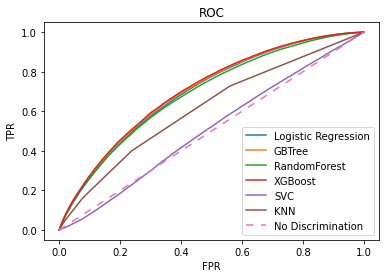

In [31]:
for key in roc_dict:
    clf = roc_dict[key]
    plt.plot(clf['fpr'], clf['tpr'], label=key)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.plot([0,1], [0,1], label='No Discrimination', linestyle='-', dashes=(5, 5))
plt.savefig(os.path.join('roc_curve_all_models.png'))
plt.legend()
plt.show()

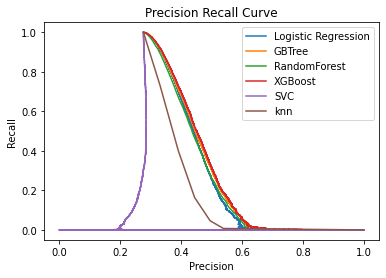

In [32]:
for key in prc_dict:
    clf = prc_dict[key]
    plt.plot(clf['precision'], clf['recall'], label=key)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Precision Recall Curve")
plt.savefig(os.path.join('prc_curve_all_models.png'))

plt.legend()

plt.show()

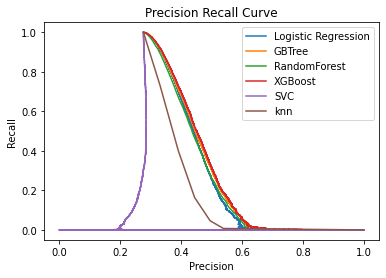

In [33]:
for key in prc_dict:
    clf = prc_dict[key]
    plt.plot(clf['precision'], clf['recall'], label=key)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Precision Recall Curve")
plt.savefig(os.path.join('prc_curve_all_models.png'))

plt.legend()

plt.show()

In [34]:
#define location to save trained model
save_model_dir = os.path.join('/content/drive/MyDrive/Models/xgb_default_params.pkl')
print("Saving model at: {}".format(save_model_dir))

#save the model
with open(save_model_dir, 'wb') as handle:
    pickle.dump(xgb_clf,
                handle,
                protocol=pickle.HIGHEST_PROTOCOL)

Saving model at: /content/drive/MyDrive/Models/xgb_default_params.pkl


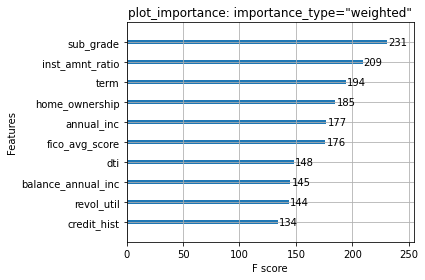

In [35]:
#”weight” is the number of times a feature appears in a tree
xgb.plot_importance(xgb_clf, 
                    importance_type='weight',
                    max_num_features=10, 
                    title='plot_importance: importance_type="weighted"')
plt.tight_layout()
plt.show()

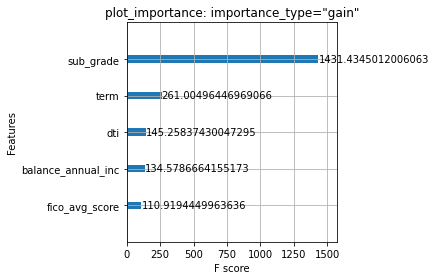

In [36]:
#”gain” is the average gain of splits which use the feature

xgb.plot_importance(xgb_clf, 
                    importance_type='gain',
                    max_num_features=5, 
                    title='plot_importance: importance_type="gain"')
plt.tight_layout()
plt.show()

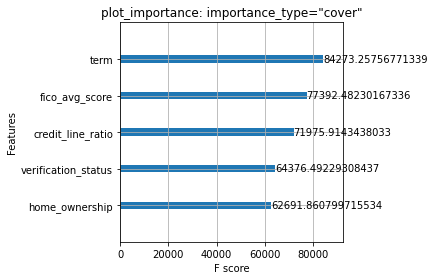

In [37]:
#is the average coverage of splits which use the feature 
#where coverage is defined as the number of samples affected by the split

xgb.plot_importance(xgb_clf, 
                    importance_type='cover',
                    max_num_features=5, 
                    title='plot_importance: importance_type="cover"')
plt.tight_layout()
plt.show()

In [38]:
y_pred=xgb_clf.predict(X_test)
y_prob=xgb_clf.predict_proba(X_test)

In [39]:
y_prob=y_prob[:, 1] #keeping only positive outcomes

In [40]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, y_pred))
# Printing the precision and recall, among other metrics
print(metrics.classification_report(y_test, y_pred))

[[137737   2793]
 [ 49636   4042]]
              precision    recall  f1-score   support

           0       0.74      0.98      0.84    140530
           1       0.59      0.08      0.13     53678

    accuracy                           0.73    194208
   macro avg       0.66      0.53      0.49    194208
weighted avg       0.70      0.73      0.64    194208



In [41]:
...
# calculate AUC
auc = roc_auc_score(y_test, y_prob)
print('AUC: %.3f' % auc)

AUC: 0.705
